### Hyper parameter tuning with GridSearchCV and RandomizedSearchCV 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('./Beer consumption.csv')
data

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900
...,...,...,...,...,...,...,...
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.rename(columns={"Data":"Date", "Temperatura Media (C)": "Temp_Medium",
                     "Temperatura Minima (C)":"Temp_Min","Temperatura Maxima (C)":"Temp_Max",
                     "Precipitacao (mm)":"Precipitaion", "Final de Semana":"Weekend", 
                     "Consumo de cerveja (litros)":"consumption"}, inplace=True)

In [4]:
data["Date"] = pd.to_datetime(data.Date)

In [5]:
data["Day"] = data.Date.dt.day
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year
data.drop(columns="Date", inplace=True)

In [6]:
data.dropna(inplace=True)

In [7]:
### Change the datatype into int
data["Day"]= data["Day"].astype("int")
data["Month"]= data["Month"].astype("int")
data["Year"]= data["Year"].astype("int")
data['Weekend'] = data['Weekend'].astype("int")

In [8]:
### Formating the columns which contains special characters like commas
for i in data.columns:
    if data[i].dtypes == "object":
        data[i]=data[i].str.replace(",",".", regex=True)

In [9]:
### We may drop the year column as there is only one year is present.
data.drop(columns="Year", inplace=True)

In [10]:
#### Lets change the object data type into float.
for i in data.columns:
    if data[i].dtypes == "object":
        data[i] = data[i].astype("float")

In [11]:
data.head()

,Temp_Medium,Temp_Min,Temp_Max,Precipitaion,Weekend,consumption,Day,Month
0,27.30,23.9,32.5,0.0,0,25.461,1,1
1,27.02,24.5,33.5,0.0,0,28.972,2,1
2,24.82,22.4,29.9,0.0,1,30.814,3,1
3,23.98,21.5,28.6,1.2,1,29.799,4,1
4,23.82,21.0,28.3,0.0,0,28.900,5,1


#### Checking for outliers

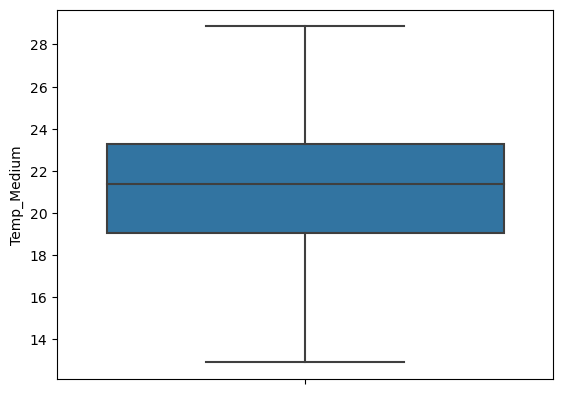

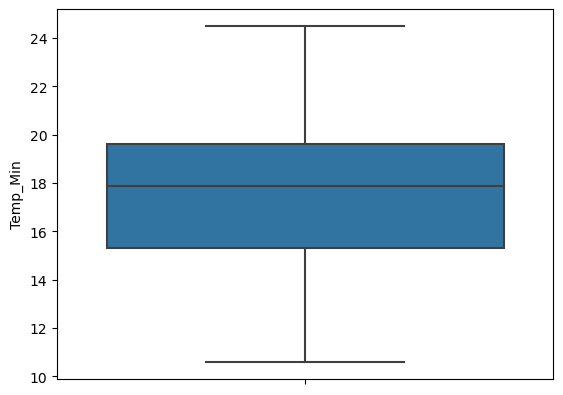

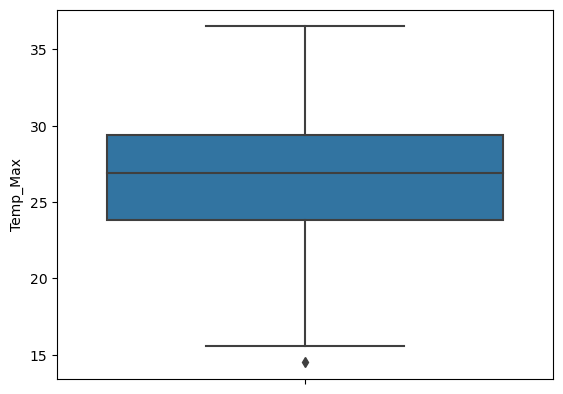

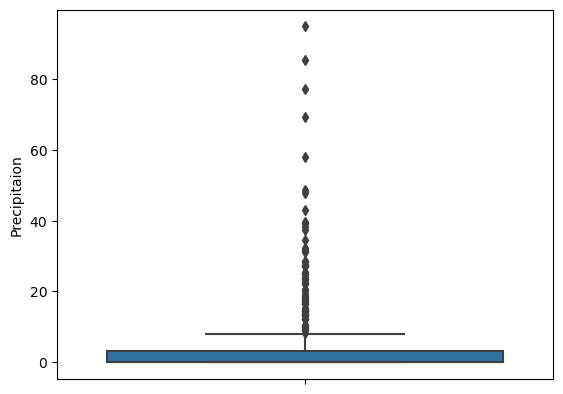

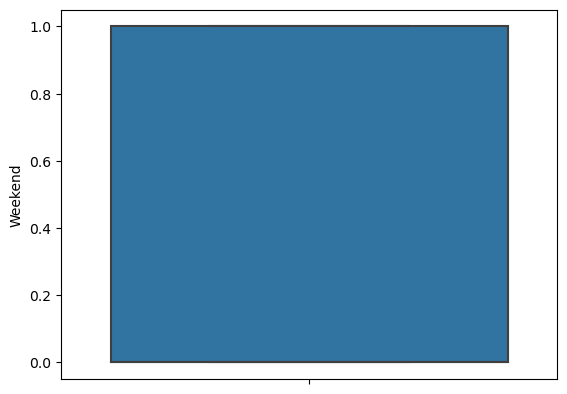

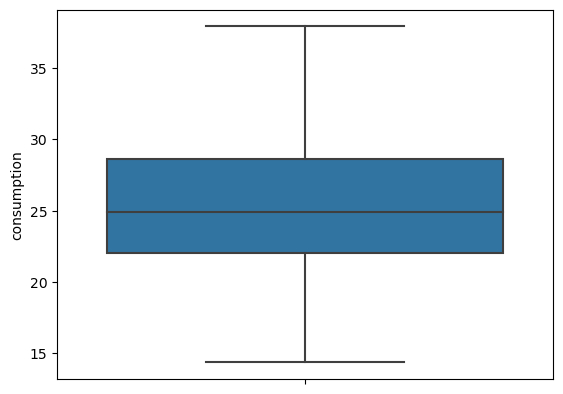

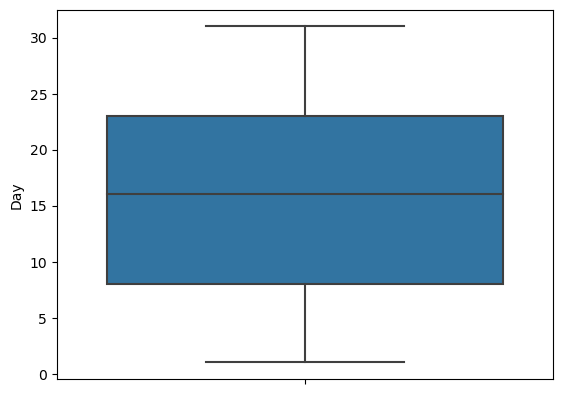

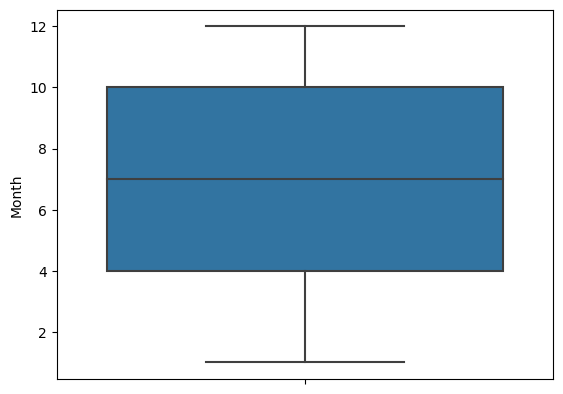

In [12]:
for i in data.columns:
    if data[i].dtype!= "object":
        sns.boxplot(y=data[i])
        plt.show()

#### Treating Outlier

In [13]:
def outlier_limit(col):
    Q3, Q1 = np.nanpercentile (col, [75,25])
    IQR = Q3 - Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*Q1
    return UL, LL

In [14]:
for column in data.columns:
    if data[column].dtype != "object":
        UL, LL = outlier_limit(data[column])
        data[column] = np.where((data[column]>UL) | (data[column]<LL),np.nan,data[column])

In [15]:
data.dropna(inplace=True)

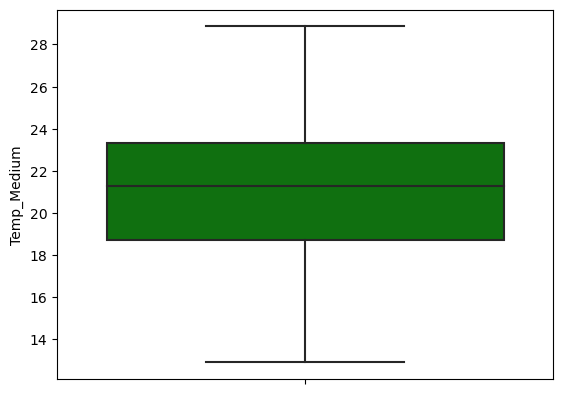

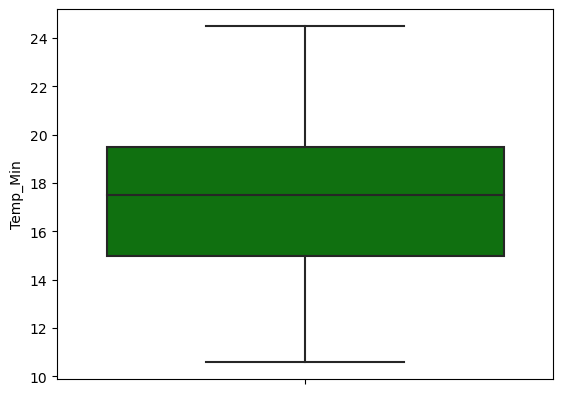

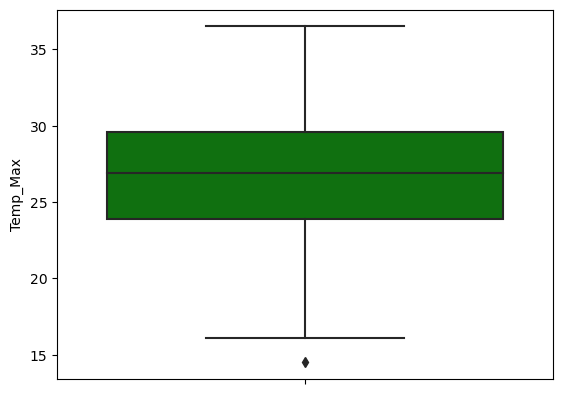

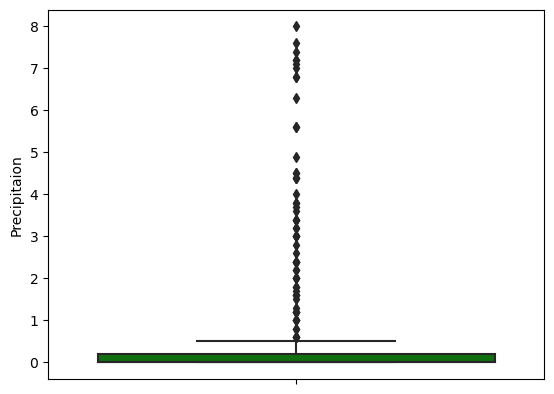

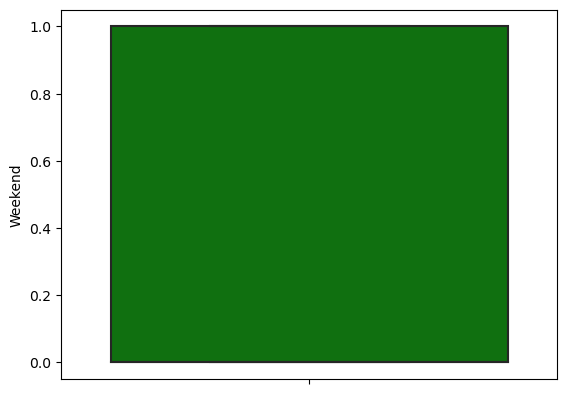

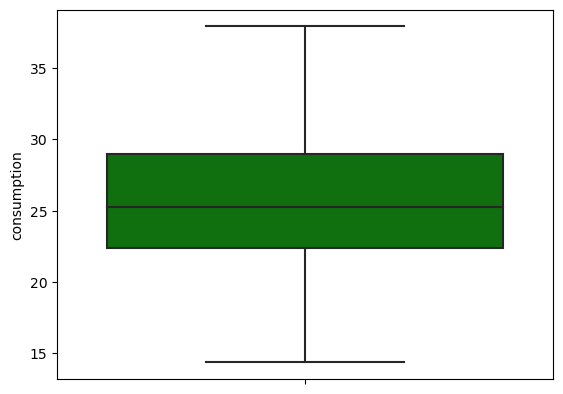

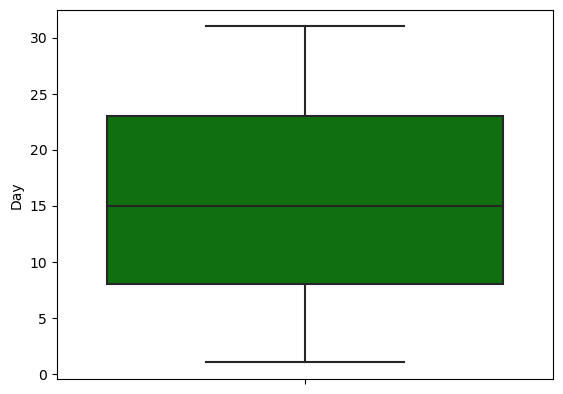

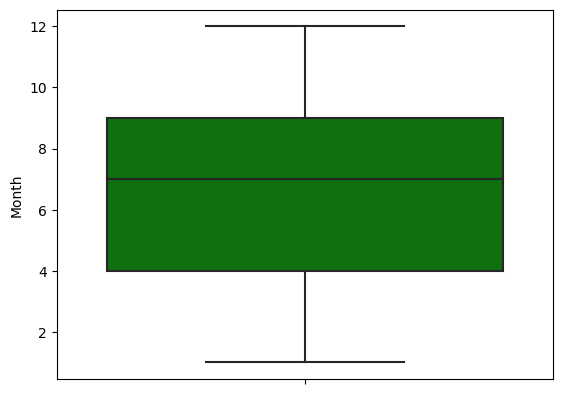

In [16]:
for i in data.columns:
    if data[i].dtype!= "object":
        sns.boxplot(y=data[i], color="Green")
        plt.show()

### Heatmap

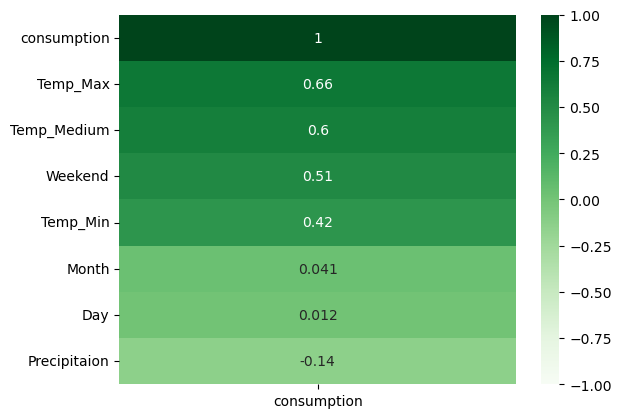

In [17]:
sns.heatmap(data.corr()[["consumption"]].sort_values(by="consumption", ascending=False), vmin=-1, vmax=1,annot=True, cmap="Greens");

### Re-arranging the columns to make new DataFrame

In [18]:
data_model = data[['Temp_Medium', 'Temp_Min', 'Temp_Max', 'Weekend', 'consumption']]
data_model

,Temp_Medium,Temp_Min,Temp_Max,Weekend,consumption
0,27.30,23.9,32.5,0.0,25.461
1,27.02,24.5,33.5,0.0,28.972
2,24.82,22.4,29.9,1.0,30.814
3,23.98,21.5,28.6,1.0,29.799
4,23.82,21.0,28.3,0.0,28.900
...,...,...,...,...,...
356,27.46,22.1,32.4,0.0,26.468
357,24.72,20.5,31.5,0.0,31.572
361,22.64,21.1,26.7,0.0,26.095
363,21.38,19.3,22.4,0.0,20.467


In [19]:
x = data_model.iloc[:, :-1].values
y = data_model.iloc[:,-1].values

### Scaling the data

In [20]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [22]:
model = RandomForestRegressor(random_state=0)

In [23]:
model.fit(x_train, y_train)
y_pred = model.predict(x)

In [24]:
model.score(x_train, y_train)*100

94.6299134763783

In [25]:
model.score(x_test, y_test)*100

72.59689841347769

In [26]:
r2_score(y_test, model.predict(x_test))*100

72.59689841347769

In [27]:
mean_absolute_error(y,y_pred)

1.0620316611295684

In [28]:
mean_squared_error(y,y_pred)

2.029761871771099

In [29]:
rmse = np.sqrt(mean_squared_error(y,y_pred))
rmse

1.4246971158007933

#### Lets see if we can increase the model perfomance by Hyper parameter tuning 

### Hyper parameter tuning

### Using RandomizedSearchCV

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#### On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

### Random Search Training

In [31]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

### Evaluate Random Search
#### To determine if random search yielded a better model, we compare the base model with the best random search model.

In [33]:
def evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 2.0454 degrees.
Accuracy = 91.82%.


In [34]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)

Model Performance
Average Error: 1.9445 degrees.
Accuracy = 92.31%.


In [35]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.54%.


### Grid Search with Cross Validation

In [36]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#### This will try out 1 * 4 * 2 * 3 * 3 * 4 = 288 combinations of settings. We can fit the model, display the best hyperparameters, and evaluate performance:

### Fit the grid search to the data

In [37]:
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [38]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test, y_test)

Model Performance
Average Error: 1.9360 degrees.
Accuracy = 92.37%.


In [39]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.60%.


#### We have improved the accuracy here by some extend.